In [8]:
import sys
sys.path.insert(0, "D:/dip/Adaptation-of-Action-Space-for-Reinforcement-Learning/")
import os
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

import matplotlib.image as mpimg
%matplotlib inline



import src.util.data as data_lib

CURRENT_DIR = os.getcwd()
DATA_TEMPLATE = "data_.*\.json.zip"

## user must set BATCH_SIZE and implement convert_episode to improve performance
def convert_episode(episode):
    '''
    episode template
    remove any useless information to deplete the file
    {
        "id":0,
        "states":[],
        "actions":[],
        "actors_actions":[],
        "ndn_actions":[],
        "rewards":[],
        "action_space_sizes":[]
    }
    '''
    del episode["states"]
    del episode["actions"]
    del episode["actors_actions"]
    del episode["ndn_actions"]
    
    episode["rewards"] = np.sum(episode["rewards"])
    episode["action_space_adaption"] = episode["action_space_sizes"][2]

    del episode["action_space_sizes"]


    
## -----------------------------------------------------------------------------
    
def get_data_filenames(deplete=True):
    all_filenames = []
    for root, subdirs, files in os.walk(CURRENT_DIR):
        for file in files:
            all_filenames.append([root, file])
    
    result_filenames = []
    
    for directory, filename in all_filenames:
        match = re.search(DATA_TEMPLATE, filename)
        if match is not None:
            
            depleted_file = "{}{}".format("light_",filename[:len(filename)-4])
            
            final_filename = None
            if not os.path.exists(directory+"/"+depleted_file) and deplete:
                data_lib.deplete(filename, convert_episode, directory)
                final_filename = depleted_file
            elif os.path.exists(directory+"/"+depleted_file):
                final_filename = depleted_file
            else:   
                final_filename = filename

            result_filenames.append(os.path.normpath("{}/{}".format(directory, final_filename)))
    return result_filenames

def load_data(filename):
    
    data_dict = data_lib.load(filename).data
    data_dict["info"] = get_data_info(data_dict, filename)
    
    return data_dict


def get_episode_data(data_dict, field):
    episodes = data_dict['simulation']['episodes']
    data = list(data[field] for data in episodes)
    return np.array(data)

def apply_func_to_window(data, window_size, func):
    data_lenght = len(data)
    window_size = min(window_size, data_lenght)
    if window_size == 0:
        window_size = (data_lenght * .1)
    res = []
    for i in range(data_lenght):
        start = int(max(i - window_size / 2, 0))
        end = int(min(i + window_size / 2, data_lenght - 1))
        if start == end:
            continue
        res.append(func(data[start:end]))

    return np.array(res)

def average_timeline(x):
    res = []
    count = 0
    total = 0
    for i in x:
        total += i
        count += 1
        res.append(total / count)
    return res

def local_maximums(data, window_size):
    data_lenght = len(data)
    window_size = min(window_size, data_lenght)
    if window_size == 0:
        window_size = (data_lenght * .1)
    res = []
    for i in range(data_lenght):
        start = int(max(i - window_size / 2, 0))
        end = int(min(i + window_size / 2, data_lenght - 1))
        if start == end:
            continue
            
        if data[i] >= np.max(data[start:end]):
            res.append(i)

    return np.array(res)

def get_data_info(data, file):
    info = {}
    
    sp = file.split("\\")
    info["filename"] = sp[len(sp)-1][6:-5]
    info["action_space_config"] = [sp[len(sp)-3], sp[len(sp)-2]]
    info["pics_dir"] = "{}/{}/{}/pics/{}".format(CURRENT_DIR, sp[len(sp)-3], sp[len(sp)-2], info["filename"] )
    info["actions"] = data["agent"]["max_actions"]
    info["knns"] = data["agent"]["k"]
    info["episodes"] = data["experiment"]["number_of_episodes"]
    info["experiment"] = data["experiment"]["name"]
        
    return info

def color_hex(n, low=0, high=1):
    return '{:02X}'.format(int(np.interp(n, [low, high], [0, 255])))




In [ ]:
def plot_data(data):
    info = data["info"]
    
    rewards = get_episode_data(data, 'rewards')


    avg_rewards = apply_func_to_window(rewards, 0, np.average)

    l_maxs = local_maximums(avg_rewards, 0)
#     print(l_maxs)

    action_space_changes = np.where(get_episode_data(data, "action_space_adaption"))[0]
#     print(action_space_changes)

    best_action_space_index = action_space_changes[np.argmin(np.abs(np.argmax(avg_rewards)-action_space_changes))]

    actions = data["info"]["actions"]
    color = "#{}00{}".format(color_hex(info["knns"], .1*actions, actions), color_hex(info["knns"], actions, 0.1*actions))
    
    plt.plot(avg_rewards, color=color, label="k={}".format(info["knns"]))
    plt.plot(l_maxs, avg_rewards[l_maxs], 'o')
    plt.plot([best_action_space_index]*2, [0, avg_rewards[best_action_space_index]], 'r')
    
    
 

In [3]:
datas = list(load_data(file) for file in get_data_filenames())

def choose_data(**kwargs):
    res = []
    
    for data in datas:
        flag = all(data["info"][key] == value for key, value in kwargs.items())
        if flag:     
            res.append(data)
    return res    

Data: Loading  D:\dip\Adaptation-of-Action-Space-for-Reinforcement-Learning\results\Wolp6\InvertedPendulum-v2\data\results\auto\square\light_data_2000_Wolp6_Inv63k12#0.json ...
Data: Loading  D:\dip\Adaptation-of-Action-Space-for-Reinforcement-Learning\results\Wolp6\InvertedPendulum-v2\data\results\auto\square\light_data_2000_Wolp6_Inv63k6#0.json ...


best action space at episode 1077


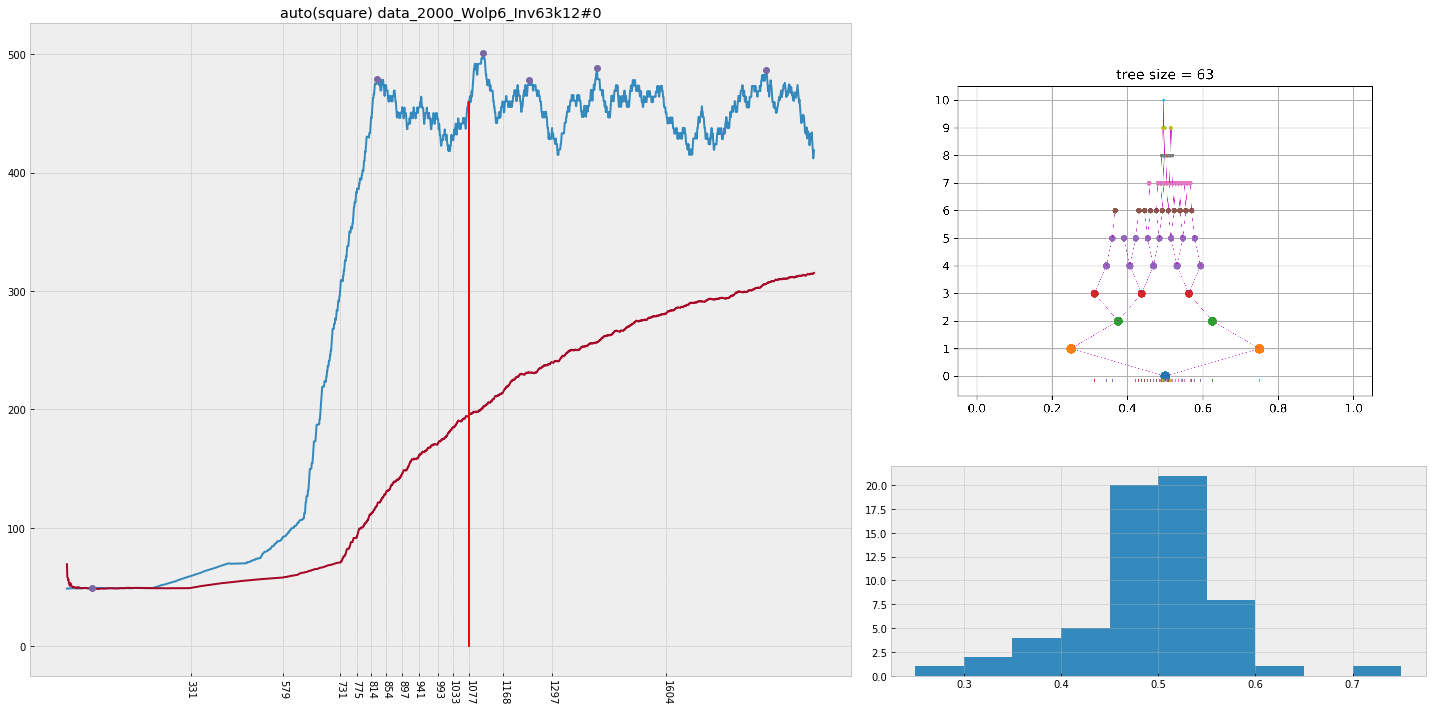

best action space at episode 653


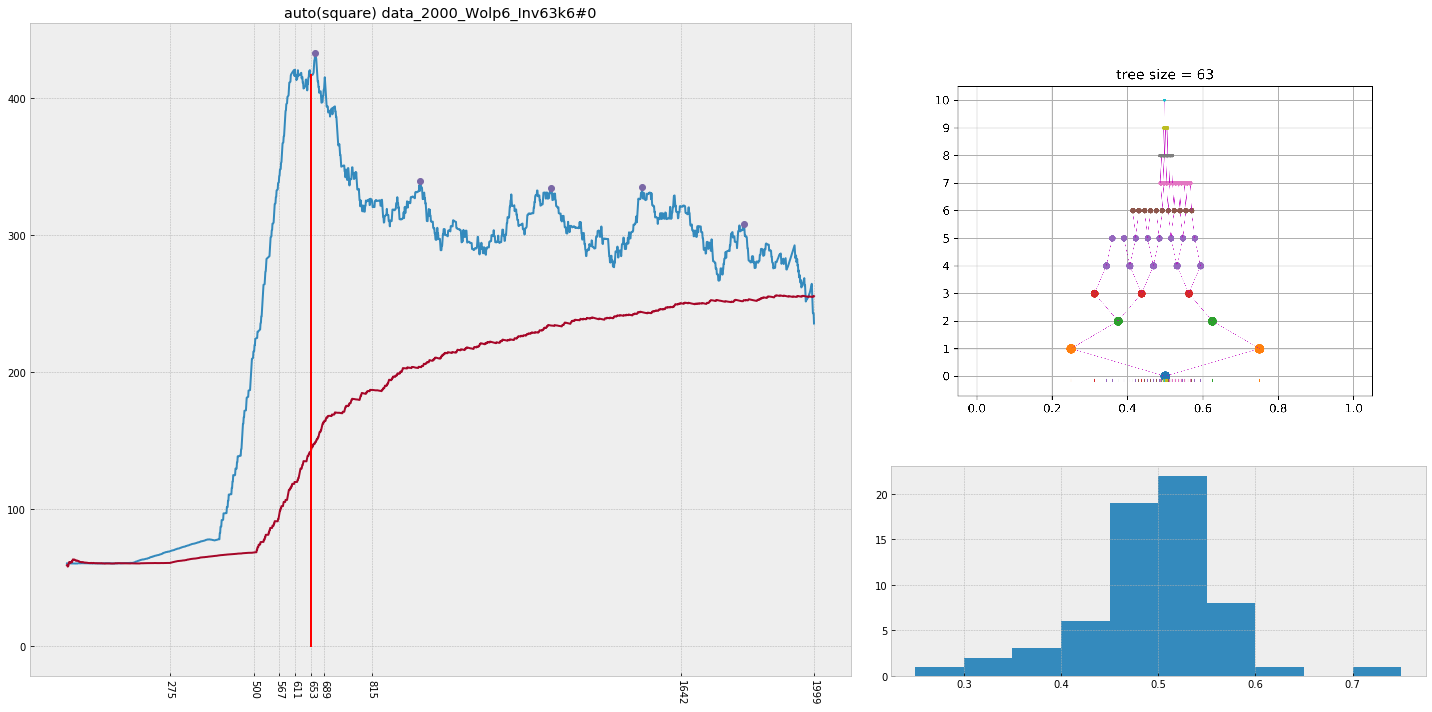

In [9]:
fig = plt.figure(figsize=(20, 10))
plt.grid(True)

for res in choose_data(actions=31):
    plot_data(res)

plt.legend()
plt.show()